Data Science Challenge for the recruiting process at Amadeus
==============

As part of the recruiting process for data scientist at Amadeus, recruiters proposed candidates to solve this data science challenge

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import bz2

%matplotlib inline

plt.style.use("ggplot")

### Exploring files using the command line

Working directory and files path:

In [2]:
!pwd

/home/dsc/Documents/python_ScientificStack


In [4]:
files_path = "../../Data/challenge"

Files to work with:

In [4]:
!ls -lh {files_path}

total 991M
-rw-rw-r--. 1 dsc dsc 530M ene  4  2016 bookings.csv.bz2
-rw-rw-r--. 1 dsc dsc 461M ene  4  2016 searches.csv.bz2


Both files are very large considering that they are compressed!!! I think it is going to be imposible to read in just one pandas dataframe. Maybe I can try to read each file by chunks...

## First Exercise: Count the number of lines in python for each file

Using the shell:

In [5]:
%time wc_bookings = !bzcat {files_path}/bookings.csv.bz2 | wc -l

CPU times: user 5.77 ms, sys: 2.6 ms, total: 8.37 ms
Wall time: 2min 6s


In [6]:
%time wc_searches = !bzcat {files_path}/searches.csv.bz2 | wc -l

CPU times: user 6.05 ms, sys: 2.47 ms, total: 8.52 ms
Wall time: 2min


In [7]:
print("There are %.d lines in bookings file and %.d lines in searches file" % (int(wc_bookings[0]), int(wc_searches[0])))

There are 10000011 lines in bookings file and 20390198 lines in searches file


Opening with python:

In [8]:
%%time
file = bz2.open(files_path+"/bookings.csv.bz2")
counter_bookings = 0
for line in file:
    counter_bookings += 1

file.close()

CPU times: user 2min 31s, sys: 1.09 s, total: 2min 32s
Wall time: 2min 36s


In [9]:
print("Bookings file has {} lines".format(counter_bookings))

Bookings file has 10000011 lines


In [10]:
%%time
file = bz2.open(files_path+"/searches.csv.bz2")
counter_searches = 0
for line in file:
    counter_searches += 1

file.close()

CPU times: user 2min 49s, sys: 433 ms, total: 2min 49s
Wall time: 2min 52s


In [11]:
print("Searches file has {} lines".format(counter_searches))

Searches file has 20390199 lines


Obviously, results are the same using the shell and opening files in python. But there is one line more in `searches.csv` file if we open it from python instead of using the shell. I do not know why!!!

## Second Exercise: Top 10 arrival airports in the world in 2013

Print the top 10 arrival airports in the standard output, including the number of passengers.

Arrival airport is the column `arr_port`. It is the IATA code for the airport. To get the total number of passengers for an airport, you can sum the column `pax`, grouping by `arr_port`. Note that there is a negative pax that corresponds to cancelations. So to get the total number of passengers that have actually booked, you should sum including the negatives (that will remove the canceled bookings).

We are going to follow the below plan of action:

* Get familiar with the data
* Select columns of interest
* Decide what to do with NaNs

* Make processing plan
* Develop code that works with a sample

* Adjust the code to work with Big data
* Test big data approach on a sample

* Run program with big data

### 1. Get familiar with the data

Let's first explore the head of the bookings file through the shell in order to see how the file looks like and get the delimiter

In [18]:
!bzcat {files_path}/bookings.csv.bz2 | head -n 10

act_date           ^source^pos_ctry^pos_iata^pos_oid  ^rloc          ^cre_date           ^duration^distance^dep_port^dep_city^dep_ctry^arr_port^arr_city^arr_ctry^lst_port^lst_city^lst_ctry^brd_port^brd_city^brd_ctry^off_port^off_city^off_ctry^mkt_port^mkt_city^mkt_ctry^intl^route          ^carrier^bkg_class^cab_class^brd_time           ^off_time           ^pax^year^month^oid      
2013-03-05 00:00:00^1A    ^DE      ^a68dd7ae953c8acfb187a1af2dcbe123^1a11ae49fcbf545fd2afc1a24d88d2b7^ea65900e72d71f4626378e2ebd298267^2013-02-22 00:00:00^1708^0^ZRH     ^ZRH     ^CH      ^LHR     ^LON     ^GB      ^ZRH     ^ZRH     ^CH      ^LHR     ^LON     ^GB      ^ZRH     ^ZRH     ^CH      ^LHRZRH  ^LONZRH  ^CHGB    ^1^LHRZRH         ^VI^T        ^Y        ^2013-03-07 08:50:00^2013-03-07 11:33:37^-1^2013^3^NULL     
2013-03-26 00:00:00^1A    ^US      ^e612b9eeeee6f17f42d9b0d3b79e75ca^7437560d8f276d6d05eeb806d9e7edee^737295a86982c941f1c2da9a46a14043^2013-03-26 00:00:00^135270^0^SAL     ^SAL     ^SV      ^

It seems that there are some extra white spaces in some string variables and column names. The delimiter between columns is a `^` symbol.

Booking dataframe sample:

In [16]:
bookings_sample = pd.read_csv(files_path+"/bookings.csv.bz2", compression = "bz2", delimiter = "^", nrows = 100000)

In [19]:
pd.set_option('display.max_columns', None) 
bookings_sample.head()

,act_date,source,pos_ctry,pos_iata,pos_oid,rloc,cre_date,duration,distance,dep_port,dep_city,dep_ctry,arr_port,arr_city,arr_ctry,lst_port,lst_city,lst_ctry,brd_port,brd_city,brd_ctry,off_port,off_city,off_ctry,mkt_port,mkt_city,mkt_ctry,intl,route,carrier,bkg_class,cab_class,brd_time,off_time,pax,year,month,oid
0,2013-03-05 00:00:00,1A,DE,a68dd7ae953c8acfb187a1af2dcbe123,1a11ae49fcbf545fd2afc1a24d88d2b7,ea65900e72d71f4626378e2ebd298267,2013-02-22 00:00:00,1708,0,ZRH,ZRH,CH,LHR,LON,GB,ZRH,ZRH,CH,LHR,LON,GB,ZRH,ZRH,CH,LHRZRH,LONZRH,CHGB,1,LHRZRH,VI,T,Y,2013-03-07 08:50:00,2013-03-07 11:33:37,-1,2013,3,NULL
1,2013-03-26 00:00:00,1A,US,e612b9eeeee6f17f42d9b0d3b79e75ca,7437560d8f276d6d05eeb806d9e7edee,737295a86982c941f1c2da9a46a14043,2013-03-26 00:00:00,135270,0,SAL,SAL,SV,CLT,CLT,US,SAL,SAL,SV,SAL,SAL,SV,CLT,CLT,US,CLTSAL,CLTSAL,SVUS,1,SALATLCLT,NV,L,Y,2013-04-12 13:04:00,2013-04-12 22:05:40,1,2013,3,NULL
2,2013-03-26 00:00:00,1A,US,e612b9eeeee6f17f42d9b0d3b79e75ca,7437560d8f276d6d05eeb806d9e7edee,737295a86982c941f1c2da9a46a14043,2013-03-26 00:00:00,135270,0,SAL,SAL,SV,CLT,CLT,US,SAL,SAL,SV,CLT,CLT,US,SAL,SAL,SV,CLTSAL,CLTSAL,SVUS,1,CLTATLSAL,NV,U,Y,2013-07-15 07:00:00,2013-07-15 11:34:51,1,2013,3,NULL
3,2013-03-26 00:00:00,1A,AU,0f984b3bb6bd06661c95529bbd6193bc,36472c6dbaf7afec9136ac40364e2794,5ecf00fdcbcec761c43dc7285253d0c1,2013-03-26 00:00:00,30885,0,AKL,AKL,NZ,SVO,MOW,RU,AKL,AKL,NZ,AKL,AKL,NZ,SVO,MOW,RU,AKLSVO,AKLMOW,NZRU,1,AKLHKGSVO,XK,G,Y,2013-04-24 23:59:00,2013-04-25 16:06:31,1,2013,3,SYDA82546
4,2013-03-26 00:00:00,1A,AU,0f984b3bb6bd06661c95529bbd6193bc,36472c6dbaf7afec9136ac40364e2794,5ecf00fdcbcec761c43dc7285253d0c1,2013-03-26 00:00:00,30885,0,AKL,AKL,NZ,SVO,MOW,RU,AKL,AKL,NZ,SVO,MOW,RU,AKL,AKL,NZ,AKLSVO,AKLMOW,NZRU,1,SVOHKGAKL,XK,G,Y,2013-05-14 20:15:00,2013-05-16 10:44:50,1,2013,3,SYDA82546


### 2. Select the columns of interest

In [20]:
bookings_sample.columns = bookings_sample.columns.str.strip()
bookings_sample.columns

Index(['act_date', 'source', 'pos_ctry', 'pos_iata', 'pos_oid', 'rloc',
       'cre_date', 'duration', 'distance', 'dep_port', 'dep_city', 'dep_ctry',
       'arr_port', 'arr_city', 'arr_ctry', 'lst_port', 'lst_city', 'lst_ctry',
       'brd_port', 'brd_city', 'brd_ctry', 'off_port', 'off_city', 'off_ctry',
       'mkt_port', 'mkt_city', 'mkt_ctry', 'intl', 'route', 'carrier',
       'bkg_class', 'cab_class', 'brd_time', 'off_time', 'pax', 'year',
       'month', 'oid'],
      dtype='object')

In [21]:
sample_cols = bookings_sample[['arr_port', 'off_time', 'pax']]
sample_cols.head()

,arr_port,off_time,pax
0,LHR,2013-03-07 11:33:37,-1
1,CLT,2013-04-12 22:05:40,1
2,CLT,2013-07-15 11:34:51,1
3,SVO,2013-04-25 16:06:31,1
4,SVO,2013-05-16 10:44:50,1


### 3. What to do with NaN?

In [22]:
sample_cols.isnull().sum()

arr_port    0
off_time    0
pax         0
dtype: int64

In [23]:
nulls_per_airport = sample_cols.groupby('arr_port').apply(lambda df: df.isnull().sum())
nulls_per_airport.head()

,arr_port,off_time,pax
arr_port,,,
AAE,0,0,0
AAL,0,0,0
AAQ,0,0,0
AAR,0,0,0
ABE,0,0,0


In [24]:
out = []

for key, group in sample_cols.groupby('arr_port'):
    group.name = key
    out.append(group.isnull().sum())

pd.concat(out, axis=1)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624,625,626,627,628,629,630,631,632,633,634,635,636,637,638,639,640,641,642,643,644,645,646,647,648,649,650,651,652,653,654,655,656,657,658,659,660,661,662,663,664,665,666,667,668,669,670,671,672,673,674,675,676,677,678,679,680,681,682,683,684,685,686,687,688,689,690,691,692,693,694,695,696,697,698,699,700,701,702,703,704,705,706,707,708,709,710,711,712,713,714,715,716,717,718,719,720,721,722,723,724,725,726,727,728,729,730,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783,784,785,786,787,788,789,790,791,792,793,794,795,796,797,798,799,800,801,802,803,804,805,806,807,808,809,810,811,812,813,814,815,816,817,818,819,820,821,822,823,824,825,826,827,828,829,830,831,832,833,834,835,836,837,838,839,840,841,842,843,844,845,846,847,848,849,850,851,852,853,854,855,856,857,858,859,860,861,862,863,864,865,866,867,868,869,870,871,872,873,874,875,876,877,878,879,880,881,882,883,884,885,886,887,888,889,890,891,892,893,894,895,896,897,898,899,900,901,902,903,904,905,906,907,908,909,910,911,912,913,914,915,916,917,918,919,920,921,922,923,924,925,926,927,928,929,930,931,932,933,934,935,936,937,938,939,940,941,942,943,944,945,946,947,948,949,950,951,952,953,954,955,956,957,958,959,960,961,962,963,964,965,966,967,968,969,970,971,972,973,974,975,976,977,978,979,980,981,982,983,984,985,986,987,988,989,990,991,992,993,994,995,996,997,998,999,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,1010,1011,1012,1013,1014,1015,1016,1017,1018,1019,1020,1021

In the sample everything might be ok, but we should prepare for NaN case

### 4. Make processing plan

1) get only the bookings from 2013

2) group by arr_port, sum

3) sort 

4) get top 10

#### 4.1 Get only the booking from 2013

In [25]:
arrivals_2013 = sample_cols['off_time'].str[:4] == '2013'
sample_cols = sample_cols[arrivals_2013]

#### 4.2 group by arr_port, sum

In [26]:
pax_per_aiport = sample_cols.groupby('arr_port')['pax'].sum()

#### 4.3,4 sort, get top 10

In [27]:
pax_per_aiport.sort_values(ascending=False).head(10)

arr_port
LHR         1006
MCO          838
JFK          792
LAX          758
BKK          740
LAS          732
SFO          698
ORD          686
CDG          673
DXB          588
Name: pax, dtype: int64

### 5. Adjust the code to work with Big data


Hint: check out https://pandas.pydata.org/pandas-docs/stable/io.html#io-chunking

In [30]:
chunks = pd.read_csv(files_path+'/bookings.csv.bz2', chunksize=100000, sep='^')
chunks

When adapting our code to use chunks, we'll process each chunk as we did the sample. After that, we'll need a way to merge the results from all chunks. In this case, it is to concatenate them and then `groupby` and `sum` again.

In [33]:
chunks = pd.read_csv(files_path+'/bookings.csv.bz2', chunksize=1000000, sep='^')

partial_results = []
chunk_num = 0

for chunk in chunks:
    
    chunk.columns = chunk.columns.str.strip()
    chunk = chunk[['arr_port', 'off_time', 'pax']]
    chunk = chunk[chunk['off_time'].str[:4] == '2013']
    
    partial_result = chunk.groupby('arr_port')['pax'].sum()
    
    partial_results.append(partial_result)
    
    print(chunk_num)
    chunk_num += 1

0
1
2
3
4


/home/dsc/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (7,8,27) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


5
6
7
8
9
10


In [36]:
top10_arr = pd.concat(partial_results)
top10_arr = top10_arr.groupby('arr_port').sum().sort_values(ascending=False).head(10)

In [37]:
top10_arr

arr_port
LHR         81439.0
LAX         64230.0
LAS         63190.0
MCO         62290.0
JFK         60060.0
CDG         58080.0
SFO         53710.0
MIA         53020.0
BKK         52660.0
DXB         52230.0
Name: pax, dtype: float64

__Bonus Point:__ Get the name of the city or airport corresponding to that airport (programatically, we suggest to have a look at GeoBases in Github)

In [38]:
from GeoBases import GeoBase

In [39]:
def get_airport_name(code):
    
    code = code.strip() # as we checked previously, there are some extra white spaces at the end of this string variable
    
    return GeoBase(data='airports', verbose=False).get(code)['name']

get_airport_name('LHR')

'London Heathrow Airport'

In [40]:
GeoBase(data='airports', verbose=False).fuzzyFind('malaga', 'name')

[(0.9, 'AGP'), (0.7692307692307693, 'PLQ'), (0.7692307692307693, 'MAK')]

In [41]:
GeoBase(data='airports', verbose=False).get('AGP')

{'__dup__': [],
 '__gar__': [],
 '__key__': 'AGP',
 '__lno__': 722,
 '__par__': [],
 'city_code': 'AGP',
 'country_code': 'ES',
 'country_name': 'Spain',
 'iata_code': 'AGP',
 'lat': '36.6749000',
 'lng': '-4.4991060',
 'name': 'Malaga / Aeropuerto'}

In [55]:
top10_arr = pd.DataFrame(top10_arr)

In [59]:
top10_arr['airport_name'] = top10_arr.index.str.strip().map(get_airport_name)
top10_arr

,pax,airport_name
arr_port,,
LHR,81439.0,London Heathrow Airport
LAX,64230.0,Los Angeles International Airport
LAS,63190.0,McCarran International Airport
MCO,62290.0,Orlando International Airport
JFK,60060.0,John F Kennedy International Airport
CDG,58080.0,Paris - Charles-de-Gaulle
SFO,53710.0,San Francisco International Airport
MIA,53020.0,Miami International Airport
BKK,52660.0,Suvarnabhumi


## Third Exercise: Plot the monthly number of searches for flights arriving at Malaga, Madrid or Barcelona

For the arriving airport you can use the `Destination` column in th searches file. Plot a curve for Malaga, another one for Madrid and another one for Barcelona, in the same figure.

### 1. Get familiar with the data

As I did with the bookings file, I am going to explore the first 5 lines through the shell:

In [60]:
!bzcat {files_path}/searches.csv.bz2 | head -n 5

Date^Time^TxnCode^OfficeID^Country^Origin^Destination^RoundTrip^NbSegments^Seg1Departure^Seg1Arrival^Seg1Date^Seg1Carrier^Seg1BookingCode^Seg2Departure^Seg2Arrival^Seg2Date^Seg2Carrier^Seg2BookingCode^Seg3Departure^Seg3Arrival^Seg3Date^Seg3Carrier^Seg3BookingCode^Seg4Departure^Seg4Arrival^Seg4Date^Seg4Carrier^Seg4BookingCode^Seg5Departure^Seg5Arrival^Seg5Date^Seg5Carrier^Seg5BookingCode^Seg6Departure^Seg6Arrival^Seg6Date^Seg6Carrier^Seg6BookingCode^From^IsPublishedForNeg^IsFromInternet^IsFromVista^TerminalID^InternetOffice
2013-01-01^20:25:57^MPT^624d8c3ac0b3a7ca03e3c167e0f48327^DE^TXL^AUH^1^2^TXL^AUH^2013-01-26^D2^^AUH^TXL^2013-02-02^D2^^^^^^^^^^^^^^^^^^^^^^1ASIWS^0^0^0^d41d8cd98f00b204e9800998ecf8427e^FRA
2013-01-01^10:15:33^MPT^b0af35b31588dc4ab06d5cf2986e8e02^MD^ATH^MIL^0^1^ATH^MIL^2013-01-04^^^^^^^^^^^^^^^^^^^^^^^^^^^^1ASIWS^0^0^0^d41d8cd98f00b204e9800998ecf8427e^KIV
2013-01-01^18:04:49^MPT^3561a60621de06ab1badc8ca55699ef3^US^ICT^SFO^1^2^ICT^SFO^2013-08-02^^^SFO^ICT^2013-08-09^^^^

In this file, the delimeter is a `^` symbol as well and it seems that there are no extra white spaces in any column.

Let's get a sample of the searches file:

In [61]:
searches_sample = pd.read_csv(files_path+"/searches.csv.bz2", compression = "bz2", delimiter = "^", nrows = 100000)
searches_sample.head()

,Date,Time,TxnCode,OfficeID,Country,Origin,Destination,RoundTrip,NbSegments,Seg1Departure,Seg1Arrival,Seg1Date,Seg1Carrier,Seg1BookingCode,Seg2Departure,Seg2Arrival,Seg2Date,Seg2Carrier,Seg2BookingCode,Seg3Departure,Seg3Arrival,Seg3Date,Seg3Carrier,Seg3BookingCode,Seg4Departure,Seg4Arrival,Seg4Date,Seg4Carrier,Seg4BookingCode,Seg5Departure,Seg5Arrival,Seg5Date,Seg5Carrier,Seg5BookingCode,Seg6Departure,Seg6Arrival,Seg6Date,Seg6Carrier,Seg6BookingCode,From,IsPublishedForNeg,IsFromInternet,IsFromVista,TerminalID,InternetOffice
0,2013-01-01,20:25:57,MPT,624d8c3ac0b3a7ca03e3c167e0f48327,DE,TXL,AUH,1,2,TXL,AUH,2013-01-26,D2,NaN,AUH,TXL,2013-02-02,D2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1ASIWS,0,0,0,d41d8cd98f00b204e9800998ecf8427e,FRA
1,2013-01-01,10:15:33,MPT,b0af35b31588dc4ab06d5cf2986e8e02,MD,ATH,MIL,0,1,ATH,MIL,2013-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1ASIWS,0,0,0,d41d8cd98f00b204e9800998ecf8427e,KIV
2,2013-01-01,18:04:49,MPT,3561a60621de06ab1badc8ca55699ef3,US,ICT,SFO,1,2,ICT,SFO,2013-08-02,NaN,NaN,SFO,ICT,2013-08-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1ASIWS,0,0,0,d41d8cd98f00b204e9800998ecf8427e,NYC
3,2013-01-01,17:42:40,FXP,1864e5e8013d9414150e91d26b6a558b,SE,RNB,ARN,0,1,RNB,ARN,2013-01-02,DU,W,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1ASI,0,0,0,d41d8cd98f00b204e9800998ecf8427e,STO
4,2013-01-01,17:48:29,MPT,1ec336348f44207d2e0027dc3a68c118,NO,OSL,MAD,1,2,OSL,MAD,2013-03-22,NaN,NaN,MAD,OSL,2013-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1ASIWS,0,0,0,d41d8cd98f00b204e9800998ecf8427e,OSL


### 2. Select the columns of interest

In [62]:
searches_sample.columns

Index(['Date', 'Time', 'TxnCode', 'OfficeID', 'Country', 'Origin',
       'Destination', 'RoundTrip', 'NbSegments', 'Seg1Departure',
       'Seg1Arrival', 'Seg1Date', 'Seg1Carrier', 'Seg1BookingCode',
       'Seg2Departure', 'Seg2Arrival', 'Seg2Date', 'Seg2Carrier',
       'Seg2BookingCode', 'Seg3Departure', 'Seg3Arrival', 'Seg3Date',
       'Seg3Carrier', 'Seg3BookingCode', 'Seg4Departure', 'Seg4Arrival',
       'Seg4Date', 'Seg4Carrier', 'Seg4BookingCode', 'Seg5Departure',
       'Seg5Arrival', 'Seg5Date', 'Seg5Carrier', 'Seg5BookingCode',
       'Seg6Departure', 'Seg6Arrival', 'Seg6Date', 'Seg6Carrier',
       'Seg6BookingCode', 'From', 'IsPublishedForNeg', 'IsFromInternet',
       'IsFromVista', 'TerminalID', 'InternetOffice'],
      dtype='object')

In [63]:
sample_cols = searches_sample[['Destination','Date']]

## 3. Make processing plan


* Filter Mad, Bcn, Agp
* Create YYYY-MM column
* Group by [destination, YYYY-MM]
* Sum
* Plot the results



### 3.1,2 Filter out the the searches for MAD, BCN, AGP

Take only the rows having MAD, BCN or AGP as destination

In [64]:
madbcnagp = sample_cols['Destination'].isin(['MAD', 'BCN', 'AGP'])

In [66]:
sample_cols = sample_cols[madbcnagp]
sample_cols.head()

,Destination,Date
4,MAD,2013-01-01
93,AGP,2013-01-01
113,BCN,2013-01-01
147,AGP,2013-01-01
151,MAD,2013-01-01


We need to get the month from the Date column

We cannot use a datetime function on 'date' column as it is string

Options:

* Using string and obtaining yyyy-mm directly from it

* Transforming string to date:      

  * parse_dates=['Date'] - in csv_read function

  * pd.to_datetime  - function

__Using directly pd.to_datetime()__:

In [67]:
as_dates = pd.to_datetime(sample_cols['Date'])

sample_cols['Month'] = as_dates.apply(lambda dt: dt.month)
sample_cols['Month'] = as_dates.dt.month
sample_cols

,Destination,Date,Month
4,MAD,2013-01-01,1
93,AGP,2013-01-01,1
113,BCN,2013-01-01,1
147,AGP,2013-01-01,1
151,MAD,2013-01-01,1
165,BCN,2013-01-01,1
177,BCN,2013-01-01,1
186,BCN,2013-01-01,1
188,BCN,2013-01-01,1
208,BCN,2013-01-01,1


__Getting PlotDate directly from the string__:

In [68]:
sample_cols['PlotDate'] = sample_cols['Date'].str[:7]
sample_cols

,Destination,Date,Month,PlotDate
4,MAD,2013-01-01,1,2013-01
93,AGP,2013-01-01,1,2013-01
113,BCN,2013-01-01,1,2013-01
147,AGP,2013-01-01,1,2013-01
151,MAD,2013-01-01,1,2013-01
165,BCN,2013-01-01,1,2013-01
177,BCN,2013-01-01,1,2013-01
186,BCN,2013-01-01,1,2013-01
188,BCN,2013-01-01,1,2013-01
208,BCN,2013-01-01,1,2013-01


## 3.3,4 Group by arr_port search month and sum the results

In [50]:
searches_per_airportmonth = sample_cols.groupby(['Destination', 'PlotDate'])['Date'].count()
searches_per_airportmonth

Destination  PlotDate
AGP          2013-01     169
             2013-02     147
             2013-03     187
             2013-04      31
BCN          2013-01     517
             2013-02     497
             2013-03     536
             2013-04     174
MAD          2013-01     425
             2013-02     400
             2013-03     433
             2013-04     147
Name: Date, dtype: int64

In [51]:
searches_per_airportmonth.reset_index()

,Destination,PlotDate,Date
0,AGP,2013-01,169
1,AGP,2013-02,147
2,AGP,2013-03,187
3,AGP,2013-04,31
4,BCN,2013-01,517
5,BCN,2013-02,497
6,BCN,2013-03,536
7,BCN,2013-04,174
8,MAD,2013-01,425
9,MAD,2013-02,400


## 4. Adjust the code to work with Big data


Again, when adapting our code to use chunks, we'll process each chunk as we did the sample. After that, we'll need a way to merge the results from all chunks. In this case, it is to concatenate them and then `groupby` and `sum` again. 

In [69]:
chunks = pd.read_csv(files_path+"/searches.csv.bz2", sep='^', chunksize=1000000)
partial_results = []
chunk_number = 0

for chunk in chunks:
    
    print(chunk_number)
    sample_cols = chunk[['Destination', 'Date']] # get columns of interest

    madbcnagp = sample_cols['Destination'].isin(['MAD', 'BCN', 'AGP']) # filtering destination we want
    sample_cols = sample_cols[madbcnagp]

    sample_cols['PlotDate'] = sample_cols['Date'].str[:7] # get the month slicing by string

    searches_per_airportmonth = sample_cols.groupby(['Destination', 'PlotDate']).count() # sum number of searches by destination and month

    unstacked = searches_per_airportmonth.reset_index()
    unstacked.columns =[ 'Destination', 'PlotDate', 'Searches'] # rename columns
    
    partial_results.append(unstacked) # append partial results
    
    chunk_number += 1

/home/dsc/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (44) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


0


/home/dsc/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (40,41,42,44) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


1
2
3
4
5
6
7
8
9
10
11
12


/home/dsc/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (29,30,31,32,33,34,35,36,37,38,44) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


13
14
15
16
17
18
19
20


In [70]:
partial_results

[   Destination PlotDate  Searches
 0          AGP  2013-01       507
 1          AGP  2013-02       441
 2          AGP  2013-03       561
 3          AGP  2013-04       435
 4          AGP  2013-05       570
 5          AGP  2013-06       417
 6          AGP  2013-07       468
 7          AGP  2013-08       414
 8          AGP  2013-09       429
 9          AGP  2013-10       271
 10         AGP  2013-11       228
 11         AGP  2013-12       132
 12         BCN  2013-01      1551
 13         BCN  2013-02      1491
 14         BCN  2013-03      1608
 15         BCN  2013-04      1644
 16         BCN  2013-05      1512
 17         BCN  2013-06      1395
 18         BCN  2013-07      1539
 19         BCN  2013-08      1425
 20         BCN  2013-09      1233
 21         BCN  2013-10       839
 22         BCN  2013-11       708
 23         BCN  2013-12       550
 24         MAD  2013-01      1275
 25         MAD  2013-02      1200
 26         MAD  2013-03      1299
 27         MAD  201

In [79]:
consolidated = pd.concat(partial_results)
aggregated = consolidated.groupby(['Destination', 'PlotDate']).sum()
aggregated

Searches
Destination PlotDate          
AGP         2013-01       9633
            2013-02       8379
            2013-03      10659
            2013-04       8265
            2013-05      10830
            2013-06       7923
            2013-07       8892
            2013-08       7866
            2013-09       8151
            2013-10       6499
            2013-11       6384
            2013-12       3696
BCN         2013-01      29469
            2013-02      28329
            2013-03      30552
            2013-04      31236
            2013-05      28728
            2013-06      26505
            2013-07      29241
            2013-08      27075
            2013-09      23427
            2013-10      20276
            2013-11      19824
            2013-12      15400
MAD         2013-01      24258
            2013-02      22800
            2013-03      24681
            2013-04      25251
            2013-05      26334
            2013-06      22800
            2013-07      22971
            2013-08      21831
            2013-09      21147
            2013-10      22294
            2013-11      20272
            2013-12      14504

## 5. Plotting...

In [80]:
aggregated = aggregated.reset_index()
aggregated = aggregated.pivot_table(index='PlotDate', columns='Destination', values='Searches')

In [78]:
aggregated

Destination,PlotDate,AGP,BCN,MAD
0,2013-01,9633,29469,24258
1,2013-02,8379,28329,22800
2,2013-03,10659,30552,24681
3,2013-04,8265,31236,25251
4,2013-05,10830,28728,26334
5,2013-06,7923,26505,22800
6,2013-07,8892,29241,22971
7,2013-08,7866,27075,21831
8,2013-09,8151,23427,21147
9,2013-10,6499,20276,22294


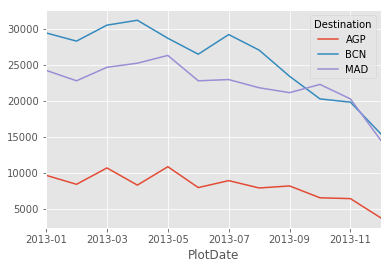

In [82]:
aggregated.plot()

## Bonus Exercise: Match searches with bookings

- For every search in the searches file, find out whether the search ended up in a booking or not (using the info in the bookings file). For instance, search and booking origin and destination should match. 

- For the bookings file, origin and destination are the columns dep_port and arr_port, respectively. 

- Generate a CSV file with the search data, and an additional field, containing 1 if the search ended up in a booking, and 0 otherwise.

We can skip some steps from the action plan, since we already did them for the other exercises. Therefore, we are going to work directly on big data code.

### 1. Processing Bookings

In [87]:
chunksize = 1e6
bookings = pd.DataFrame()
bookings_reader = pd.read_csv(files_path+"/bookings.csv.bz2", 
                     usecols = ['dep_port','arr_port','cre_date           '], 
                     delimiter = "^", chunksize = chunksize)

chunk_counter = 0

for chunk in bookings_reader:
    print(chunk_counter)
    
    # String airport codes in departure and arrival variables 
    chunk['dep_port'] = chunk['dep_port'].str.strip()
    chunk['arr_port'] = chunk['arr_port'].str.strip()
    
    # Get date
    chunk['date'] = chunk['cre_date           '].str[:10]
    chunk['booked'] = 1 # We are going to considerer that if the departure, arrival and day of the year match, the search ended up wiht a booked
    
    chunk.drop('cre_date           ',axis=1,inplace=True) #droping date from original chunk
    chunk.drop_duplicates(inplace = True) #droping duplicates
    
    chunk_counter += 1
    
    bookings = pd.concat([bookings,chunk])

0
1
2
3
4
5
6
7
8
9
10


In [89]:
bookings.head()

,dep_port,arr_port,date,booked
0,ZRH,LHR,2013-02-22,1
1,SAL,CLT,2013-03-26,1
3,AKL,SVO,2013-03-26,1
5,DEN,LGA,2013-03-20,1
7,NRT,SIN,2013-03-25,1


### 2. Match searches with processed bookings

For this final part of the challenge, we are going to read onlye 1000000 rows of the searches file in order to avoid waiting too much in the writing procces.

In [92]:
chunksize = 1e5
searches_booked = pd.DataFrame()
searches_reader = pd.read_csv(files_path+"/searches.csv.bz2", 
                     delimiter = "^", chunksize = chunksize, nrows = 1e6)

chunk_counter = 0

for chunk in searches_reader:
    print(chunk_counter)
    
    chunk = chunk.reset_index().merge(bookings, left_on=['Origin','Destination','Date'], 
                                      right_on=['dep_port','arr_port','date'], how = 'left') # left join
    
    chunk.drop(['dep_port','arr_port','date'], axis = 1, inplace = True) # drop columns from bookings
    chunk['booked'][chunk['booked'].isnull()] = 0 # completing unmatched rows
    
    searches_booked = pd.concat([searches_booked,chunk])
    
    searches_booked.to_csv("bonusExercise.csv.bz2",compression = "bz2", mode = "a", sep = '^', 
                           #header = counter == 0, index = False) # writing in a file
    chunk_counter += 1

0


/home/dsc/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


1


/home/dsc/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (44) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


2
3
4
5
6
7
8
9


In [93]:
searches_booked.head()

,index,Date,Time,TxnCode,OfficeID,Country,Origin,Destination,RoundTrip,NbSegments,Seg1Departure,Seg1Arrival,Seg1Date,Seg1Carrier,Seg1BookingCode,Seg2Departure,Seg2Arrival,Seg2Date,Seg2Carrier,Seg2BookingCode,Seg3Departure,Seg3Arrival,Seg3Date,Seg3Carrier,Seg3BookingCode,Seg4Departure,Seg4Arrival,Seg4Date,Seg4Carrier,Seg4BookingCode,Seg5Departure,Seg5Arrival,Seg5Date,Seg5Carrier,Seg5BookingCode,Seg6Departure,Seg6Arrival,Seg6Date,Seg6Carrier,Seg6BookingCode,From,IsPublishedForNeg,IsFromInternet,IsFromVista,TerminalID,InternetOffice,booked
0,0,2013-01-01,20:25:57,MPT,624d8c3ac0b3a7ca03e3c167e0f48327,DE,TXL,AUH,1,2,TXL,AUH,2013-01-26,D2,NaN,AUH,TXL,2013-02-02,D2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1ASIWS,0,0,0,d41d8cd98f00b204e9800998ecf8427e,FRA,0.0
1,1,2013-01-01,10:15:33,MPT,b0af35b31588dc4ab06d5cf2986e8e02,MD,ATH,MIL,0,1,ATH,MIL,2013-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1ASIWS,0,0,0,d41d8cd98f00b204e9800998ecf8427e,KIV,0.0
2,2,2013-01-01,18:04:49,MPT,3561a60621de06ab1badc8ca55699ef3,US,ICT,SFO,1,2,ICT,SFO,2013-08-02,NaN,NaN,SFO,ICT,2013-08-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1ASIWS,0,0,0,d41d8cd98f00b204e9800998ecf8427e,NYC,0.0
3,3,2013-01-01,17:42:40,FXP,1864e5e8013d9414150e91d26b6a558b,SE,RNB,ARN,0,1,RNB,ARN,2013-01-02,DU,W,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1ASI,0,0,0,d41d8cd98f00b204e9800998ecf8427e,STO,0.0
4,4,2013-01-01,17:48:29,MPT,1ec336348f44207d2e0027dc3a68c118,NO,OSL,MAD,1,2,OSL,MAD,2013-03-22,NaN,NaN,MAD,OSL,2013-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1ASIWS,0,0,0,d41d8cd98f00b204e9800998ecf8427e,OSL,0.0
